<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter5/5_1_%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB_NumPyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install packages
!pip install watermark
!pip install japanize-matplotlib
# !pip install numpyro==0.8.0
!pip install numpyro
# !pip install jax==0.2.21
!pip install jax

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [ ]:
import jax.numpy as jnp
import jax.random as random
 
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

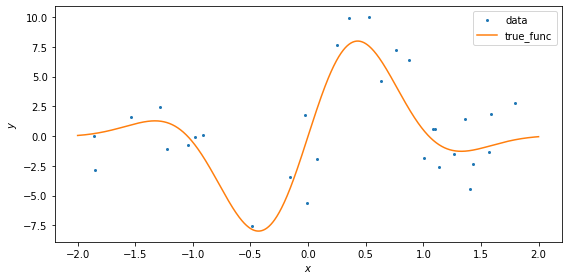

In [ ]:
np.random.seed(20)

# データ数
N = 30

# 目的変数生成関数
def make_data(x, eps):
  y = 10*np.sin(3*x) * np.exp(-x**2)
  noise = np.random.normal(0, eps, size=x.shape[0])
  return y+ noise

# 説明変数をサンプリング
x_data = np.random.uniform(low=-2., high=2., size=N)
# 目的変数生成
y_data =  make_data(x_data, 2.0)
# 関数可視化用説明変数
x_linspace = np.linspace(-2., 2., 1000)
# 関数可視化用目的変数
y_linspace = make_data(x_linspace, 0.0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_data, y_data, 'o', markersize=2, label='data');
ax.plot(x_linspace, y_linspace, label='true_func')
ax.set_xlabel('$x$');ax.set_ylabel('$y$')
ax.legend()
plt.tight_layout();

In [ ]:
# 隠れ層の次元
h1, h2 = 10, 10

# relu関数
def relu(x):
    return jnp.maximum(x, 0.)

def model(X, Y, h1, h2):
    # バイアス付与
    X = jnp.power(X, jnp.arange(2))
    D_X = X.shape[1]
    
    # 第1層の重みをサンプリング
    w1 = numpyro.sample(
        "w1", dist.Normal(jnp.zeros((D_X, h1)), 10.0*jnp.ones((D_X, h1))).to_event(2)
    ) 
    # 第1層の線形結合と非線形変換
    z1 = relu(jnp.matmul(X, w1))  

    # 第2層の重みをサンプリング
    w2 = numpyro.sample(
        "w2", dist.Normal(jnp.zeros((h1, h2)), 10.0*jnp.ones((h1, h2))).to_event(2)
    )  
    # 第2層の線形結合と非線形変換
    z2 = relu(jnp.matmul(z1, w2))

    # 出力層の重みをサンプリング
    w3 = numpyro.sample(
        "w3", dist.Normal(jnp.zeros((h2, 1)), 10.0*jnp.ones((h2, 1))).to_event(2)
    )  
    # 出力層の線形結合と非線形変換
    z3 = jnp.matmul(z2, w3) 

    # 観測ノイズの標準偏差をサンプリング
    sigma_obs = numpyro.sample('noise_obs', dist.Uniform(0.0, 2.0))
    # 尤度の積
    with numpyro.plate("data", X.shape[0]):
      obs = numpyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1), obs=Y)

    # 全ての軸をevent_shapeにしても計算はできる
    # obs = numpyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(2), obs=Y)

In [ ]:
# NUTによるMCMCの設定
def run_inference(model, rng_key, X, Y, h1, h2):
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=2000,
        num_chains=1,
    )
    mcmc.run(rng_key, X, Y, h1, h2)
    return mcmc.get_samples()

# データをjax.numpy型に変換
x_data = jnp.array(x_data)[:,jnp.newaxis]
y_data = jnp.array(y_data)[:,jnp.newaxis]

# 疑似乱数生成器
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

# 推論の実行（y_dataのshapeを(30, )から(30, 1)にする））
samples = run_inference(model, rng_key, x_data, y_data, h1, h2)

sample: 100%|██████████| 3000/3000 [00:53<00:00, 56.04it/s, 1023 steps of size 8.66e-04. acc. prob=0.77]


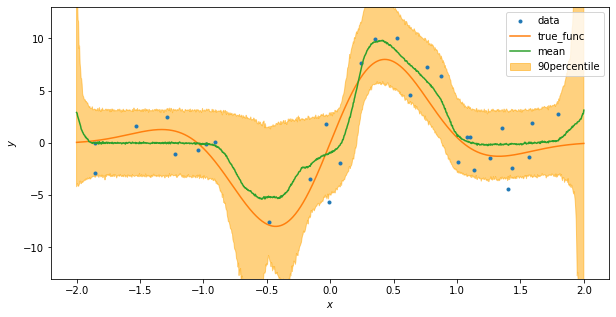

In [ ]:
# MCMCサンプルを利用した予測分布
predictive = Predictive(model, samples)

# 新規データ
x_new = jnp.linspace(-2.0, 2.0, 1000)[:,jnp.newaxis]
# 新規データを入力して予測分布を出力
y_pred_samples = predictive(rng_key_predict, X=x_new, Y=None, h1=h1, h2=h2)['Y']
# 予測分布のからのサンプルの平均
y_pred_mean = y_pred_samples.mean(axis=0)
# 予測分布からのサンプルの90パーセンタイル
percentiles = np.percentile(y_pred_samples.squeeze(-1), [5.0, 95.0], axis=0)

fig, ax = plt.subplots(figsize=(10, 5))
# データ可視化
ax.plot(x_data, y_data, 'o', markersize=3, label='data')
# 真の関数
ax.plot(x_linspace, y_linspace, label='true_func')
# 予測分布の平均
ax.plot(x_new, y_pred_mean, label='mean')
# 予測分布の90パーセンタイル
ax.fill_between(x_new.squeeze(-1), percentiles[0, :], percentiles[1, :],
                  alpha=0.5, label='90percentile', color='orange')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_ylim(-13 ,13)
ax.legend();

In [ ]:
%load_ext watermark
%watermark --iversions

numpyro   : 0.9.2
numpy     : 1.21.6
scipy     : 1.4.1
IPython   : 5.5.0
jax       : 0.3.8
matplotlib: 3.2.2
arviz     : 0.12.1
pandas    : 1.3.5
seaborn   : 0.11.2

